- Dropout

- Early Stopping 최적의 model

- Xception
https://keras.io/api/applications/

- Data Augmentation


< Transfer Learning >
- Freeze CNN
- Fine Tuning


In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
# 드라이브 마운트

In [2]:
import tensorflow as tf
tf.test.gpu_device_name() # GPU 사용중인지 확인

'/device:GPU:0'

# Convolutional Neural Networks : Classification Assignment

# Data 

## Loading Data

* 공유 드라이브에서 데이터셋 가져오기

In [3]:
import os, shutil

In [4]:
# 기본 경로
original_dir='/content/drive/Shareddrives/Practical_Computer_Vision/week_2/Classification'
base_dir='/content/drive/MyDrive/datasets'

# if os.path.exists(base_dir):  # 반복적인 실행을 위해 디렉토리를 삭제합니다.
#     shutil.rmtree(base_dir)   # 이 코드는 책에 포함되어 있지 않습니다.
# os.mkdir(base_dir)

train_dir=os.path.join(base_dir,'train')
# os.mkdir(train_dir)

valid_dir=os.path.join(base_dir,'validation')
# os.mkdir(valid_dir)

test_dir=os.path.join(original_dir,'test')


org_train_dir=os.path.join(original_dir,'train')


In [5]:
label_names=os.listdir(org_train_dir)
print(label_names)

['glacier', 'buildings', 'forest', 'street', 'sea', 'mountain']


In [6]:
for names in label_names:
  a=os.path.join(org_train_dir,names)
  tra_tmp=os.path.join(train_dir,names)
  os.mkdir(tra_tmp)
  val_tmp=os.path.join(valid_dir,names)
  os.mkdir(val_tmp)
  
  number_of_files=len(os.listdir(a))
  files=os.listdir(a)

  for fname in files[:number_of_files//3]: # 1/3만큼 validation data 생성
    src=os.path.join(a,fname)
    dst=os.path.join(val_tmp,fname)
    shutil.copyfile(src,dst)

  for fname in files[number_of_files//3:]: # 나머지 2/3만큼 train data 생성
    src=os.path.join(a,fname)
    dst=os.path.join(tra_tmp,fname)
    shutil.copyfile(src,dst)


In [7]:
#알맞게 복사됐는지 확인
for names in label_names:
  tra_tmp=os.path.join(train_dir,names)
  val_tmp=os.path.join(valid_dir,names)

  print(names)
  print(f'Number of Train, {names} data : {len(os.listdir(tra_tmp))}')
  print(f'Number of Validation, {names} data : {len(os.listdir(val_tmp))}')



## Data Preprocessing

In [8]:
from keras.preprocessing.image import ImageDataGenerator

# 모든 이미지를 1/255로 스케일 조정
train_datagen=ImageDataGenerator(rescale=1.0/255.)
validation_datagen=ImageDataGenerator(rescale=1.0/255.)
# test_datagen=ImageDataGenerator(rescale=1.0/255.)

train_generator = train_datagen.flow_from_directory(
        # 타깃 디렉터리
        train_dir,
        # 모든 이미지를 150 × 150 크기로 바꿉니다
        target_size=(150, 150),
        batch_size=20,
        # categorical_crossentropy 손실을 사용하기 때문에 다중 레이블이 필요합니다
        class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
        # 타깃 디렉터리
        valid_dir,
        # 모든 이미지를 150 × 150 크기로 바꿉니다
        target_size=(150, 150),
        batch_size=20,
        # categorical_crossentropy 손실을 사용하기 때문에 다중 레이블이 필요합니다
        class_mode='categorical')



Found 9357 images belonging to 6 classes.
Found 4677 images belonging to 6 classes.


In [9]:
for data_batch, labels_batch in train_generator:
    print('배치 데이터 크기:', data_batch.shape)
    print('배치 레이블 크기:', labels_batch.shape)
    break

배치 데이터 크기: (20, 150, 150, 3)
배치 레이블 크기: (20, 6)


# Build Model

## Freeze CNN

### Freeze CNN-1

https://keras.io/api/applications/


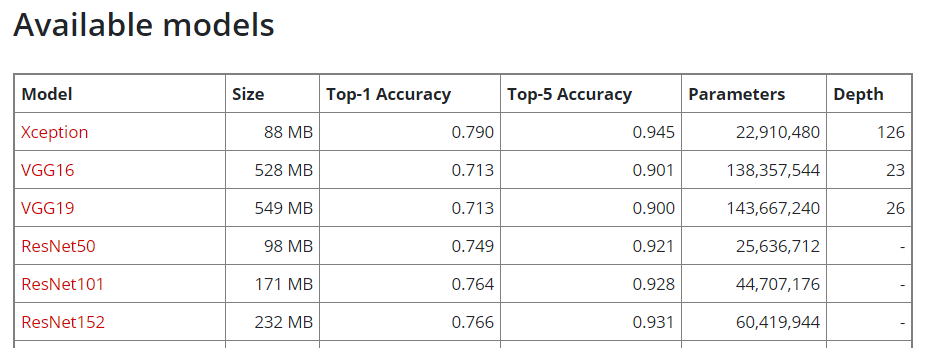

In [10]:
from keras.applications import Xception

In [12]:
conv_base=Xception(include_top=False,
                   weights='imagenet',
                   input_shape=(150,150,3))

83689472/83683744 [==============================] - 0s 0us/step


In [13]:
conv_base.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 74, 74, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 74, 74, 32)   0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [14]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255.)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 5, 5, 2048))
    labels = np.zeros(shape=(sample_count,6))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # 제너레이터는 루프 안에서 무한하게 데이터를 만들어내므로 모든 이미지를 한 번씩 처리하고 나면 중지합니다
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(valid_dir, 1000)

Found 9357 images belonging to 6 classes.
Found 4677 images belonging to 6 classes.


In [17]:
train_features = np.reshape(train_features, (2000, 5 * 5 * 2048))
validation_features = np.reshape(validation_features, (1000, 5 * 5 * 2048))

In [18]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=5 * 5 * 2048))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(6, activation='softmax'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Epoch 1/30
100/100 [==============================] - 2s 14ms/step - loss: 0.8831 - acc: 0.6895 - val_loss: 0.3217 - val_acc: 0.8830
Epoch 2/30
100/100 [==============================] - 1s 10ms/step - loss: 0.3447 - acc: 0.8771 - val_loss: 0.2977 - val_acc: 0.8980
Epoch 3/30
100/100 [==============================] - 1s 10ms/step - loss: 0.2279 - acc: 0.9251 - val_loss: 0.2982 - val_acc: 0.8970
Epoch 4/30
100/100 [==============================] - 1s 10ms/step - loss: 0.1834 - acc: 0.9406 - val_loss: 0.3195 - val_acc: 0.8910
Epoch 5/30
100/100 [==============================] - 1s 10ms/step - loss: 0.1350 - acc: 0.9482 - val_loss: 0.3223 - val_acc: 0.9040
Epoch 6/30
100/100 [==============================] - 1s 10ms/step - loss: 0.1475 - acc: 0.9466 - val_loss: 0.3274 - val_acc: 0.9030
Epoch 7/30
100/100 [==============================] - 1s 10ms/step - loss: 0.1241 - acc: 0.9562 - val_loss: 0.3133 - val_acc: 0.9050
Epoch 8/30
100/100 [==============================] - 1s 10ms/step - 

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 256)               13107456  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 1542      
Total params: 13,108,998
Trainable params: 13,108,998
Non-trainable params: 0
_________________________________________________________________


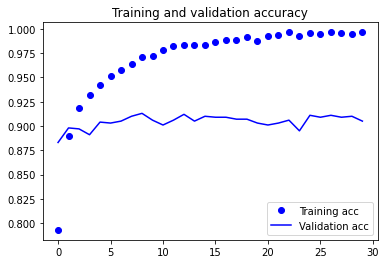

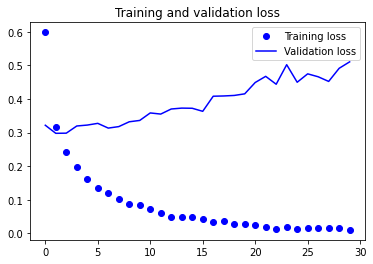

In [20]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Freeze CNN-2

In [21]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
flatten (Flatten)            (None, 51200)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               13107456  
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 1542      
Total params: 33,970,478
Trainable params: 33,915,950
Non-trainable params: 54,528
_________________________________________________________________


In [23]:
print('conv_base를 동결하기 전 훈련되는 가중치의 수:', 
      len(model.trainable_weights))

conv_base를 동결하기 전 훈련되는 가중치의 수: 158


In [24]:
conv_base.trainable = False

In [25]:
print('conv_base를 동결한 후 훈련되는 가중치의 수:', 
      len(model.trainable_weights))

conv_base를 동결한 후 훈련되는 가중치의 수: 4


In [26]:
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop

train_datagen2 = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=0.1,
      horizontal_flip=True,
      fill_mode='nearest')

# 검증 데이터는 증식되어서는 안됨
valid_datagen2 = ImageDataGenerator(rescale=1./255)

train_generator2 = train_datagen2.flow_from_directory(
        # 타깃 디렉터리
        train_dir,
        # 모든 이미지의 크기를 150 × 150로 변경합니다
        target_size=(150, 150),
        batch_size=20,
        # categorical_crossentropy 손실을 사용하므로 다중 레이블이 필요합니다
        class_mode='categorical')

valid_generator2 = valid_datagen2.flow_from_directory(
        valid_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=2e-5),
              metrics=['acc'])


Found 9357 images belonging to 6 classes.
Found 4677 images belonging to 6 classes.


In [27]:
history = model.fit_generator(
      train_generator2,
      steps_per_epoch=100,
      epochs=30,
      validation_data=valid_generator2,
      validation_steps=50)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
100/100 [==============================] - 1277s 13s/step - loss: 0.7886 - acc: 0.7251 - val_loss: 0.3980 - val_acc: 0.8540
Epoch 2/30
100/100 [==============================] - 1017s 10s/step - loss: 0.3996 - acc: 0.8487 - val_loss: 0.3224 - val_acc: 0.8980
Epoch 3/30
100/100 [==============================] - 796s 8s/step - loss: 0.4310 - acc: 0.8585 - val_loss: 0.3036 - val_acc: 0.8900
Epoch 4/30
100/100 [==============================] - 637s 6s/step - loss: 0.3846 - acc: 0.8489 - val_loss: 0.3213 - val_acc: 0.8720
Epoch 5/30
100/100 [==============================] - 483s 5s/step - loss: 0.3383 - acc: 0.8760 - val_loss: 0.3337 - val_acc: 0.8780
Epoch 6/30
100/100 [==============================] - 386s 4s/step - loss: 0.3149 - acc: 0.8910 - val_loss: 0.2869 - val_acc: 0.8970
Epoch 7/30
100/100 [==============================] - 332s 3s/step - loss: 0.3392 - acc: 0.8777 - val_loss: 0.3081 - val_acc: 0.8970
Epoch 8/30
100/100 [==============================] - 246s 2s/ste

In [28]:
model.save('freezecnn.h5')

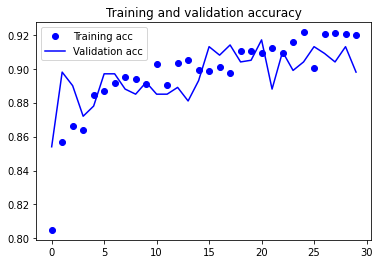

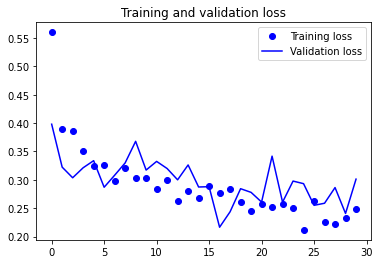

In [29]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Fine Tuning

In [30]:
conv_base.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 74, 74, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 74, 74, 32)   0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [31]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block14_sepconv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [49]:
# 사용자 정의 콜백 함수
from tensorflow.keras.callbacks import Callback

class my_callback(Callback):
  def on_epoch_end(self,epoch,logs={}):
    if(logs.get('val_acc')>0.925):
      self.model.stop_traing=True
      print('\n')
      print('목표 정확도 달성 : 검증 정확도 : %.4f'%logs.get('val.acc'))

my_callback=my_callback()

# Best model 저장

from tensorflow.keras.callbacks import ModelCheckpoint

best_model_path='best_finetuning.h5'
save_best_model=ModelCheckpoint(best_model_path,monitor='val_loss',
                                save_best_only=True,save_weights_only=False)


In [50]:
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=40,
      validation_data=validation_generator,
      callbacks=[my_callback,save_best_model],
      validation_steps=50)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
100/100 [==============================] - 10s 77ms/step - loss: 0.0493 - acc: 0.9846 - val_loss: 0.3307 - val_acc: 0.9190
Epoch 2/40
100/100 [==============================] - 7s 72ms/step - loss: 0.0395 - acc: 0.9855 - val_loss: 0.3690 - val_acc: 0.9180
Epoch 3/40
100/100 [==============================] - 7s 70ms/step - loss: 0.0382 - acc: 0.9887 - val_loss: 0.3506 - val_acc: 0.9100
Epoch 4/40
100/100 [==============================] - 7s 71ms/step - loss: 0.0474 - acc: 0.9854 - val_loss: 0.3668 - val_acc: 0.8920
Epoch 5/40
100/100 [==============================] - 7s 72ms/step - loss: 0.0365 - acc: 0.9879 - val_loss: 0.3908 - val_acc: 0.9050
Epoch 6/40
100/100 [==============================] - 7s 72ms/step - loss: 0.0425 - acc: 0.9853 - val_loss: 0.3741 - val_acc: 0.9130
Epoch 7/40
100/100 [==============================] - 7s 72ms/step - loss: 0.0359 - acc: 0.9883 - val_loss: 0.3512 - val_acc: 0.9110
Epoch 8/40
100/100 [==============================] - 7s 72ms/step -

TypeError: ignored

In [51]:
model.save('finetuning2.h5')

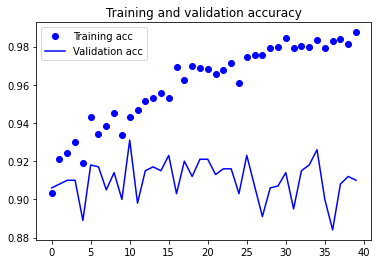

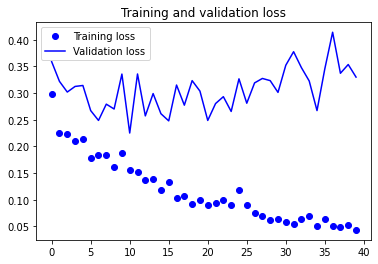

In [52]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Submission


In [35]:
from keras.models import load_model

In [36]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
flatten (Flatten)            (None, 51200)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               13107456  
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 1542      
Total params: 33,970,478
Trainable params: 17,857,798
Non-trainable params: 16,112,680
_________________________________________________________________


In [53]:
import cv2
import os

test_dir2='/content/drive/Shareddrives/Practical_Computer_Vision/week_2/Classification/test'
fnames=os.listdir(test_dir)
mapping={0:'buildings',1:'forest',2:'glacier',3:'mountain',4:'sea',5:'street'}

In [54]:
#원리
img_BGR=cv2.imread(test_dir2+'/'+fnames[16],cv2.IMREAD_COLOR)
img_RGB=cv2.cvtColor(img_BGR,cv2.COLOR_BGR2RGB)

img_RGB=cv2.resize(img_RGB,(150,150),interpolation=cv2.INTER_LINEAR)

img_RGB=np.expand_dims(img_RGB,0)
img_RGB=img_RGB/255.

print(img_RGB.shape)
print(img_RGB)
print(fnames[16],mapping[np.argmax(model.predict(img_RGB))])

(1, 150, 150, 3)
[[[[0.08627451 0.11372549 0.08627451]
   [0.04705882 0.07843137 0.02745098]
   [0.08235294 0.11372549 0.02352941]
   ...
   [0.85098039 0.87058824 0.84313725]
   [0.94117647 0.94509804 0.91372549]
   [0.63529412 0.63921569 0.60784314]]

  [[0.14509804 0.17254902 0.14509804]
   [0.15294118 0.18431373 0.14117647]
   [0.01960784 0.04705882 0.        ]
   ...
   [0.8        0.81960784 0.79607843]
   [0.77254902 0.78431373 0.75686275]
   [0.17647059 0.18039216 0.15686275]]

  [[0.00392157 0.03921569 0.01960784]
   [0.09019608 0.1254902  0.10588235]
   [0.27843137 0.30588235 0.27843137]
   ...
   [0.88235294 0.89803922 0.89411765]
   [0.70588235 0.71372549 0.70196078]
   [0.02352941 0.03137255 0.01960784]]

  ...

  [[0.48235294 0.51764706 0.50588235]
   [0.51372549 0.5372549  0.52156863]
   [0.63137255 0.64313725 0.60784314]
   ...
   [0.56862745 0.58431373 0.58039216]
   [0.30980392 0.33333333 0.3254902 ]
   [0.43137255 0.45490196 0.44705882]]

  [[0.54509804 0.57647059 0.

In [55]:
import pandas as pd

output=[]
mapping={0:'buildings',1:'forest',2:'glacier',3:'mountain',4:'sea',5:'street'}

for file in fnames:
  tmp=[]
  img_BGR=cv2.imread(test_dir2+'/'+file,cv2.IMREAD_COLOR)
  img_RGB=cv2.cvtColor(img_BGR,cv2.COLOR_BGR2RGB)
  img_RGB=cv2.resize(img_RGB,(150,150),interpolation=cv2.INTER_LINEAR)
  img_RGB=np.expand_dims(img_RGB,0)
  img_RGB=img_RGB/255.

  a=mapping[np.argmax(model.predict(img_RGB))]
  tmp.append(file)
  tmp.append(a)
  output.append(tmp)




In [56]:
import pandas as pd

output1=pd.DataFrame(output)
output1.head(5)



,0,1
0,20498.jpg,street
1,20270.jpg,street
2,20388.jpg,street
3,20464.jpg,street
4,20670.jpg,street


In [57]:
output1.columns=['name','class']
ans=output1.sort_values(by='name')
ans.head(10)


,name,class
2455,20056.jpg,forest
2762,20057.jpg,buildings
1688,20058.jpg,sea
2043,20059.jpg,glacier
2767,20060.jpg,buildings
2768,20061.jpg,buildings
2477,20062.jpg,forest
2771,20064.jpg,buildings
892,20066.jpg,street
898,20067.jpg,buildings


In [58]:
ans.index

Int64Index([2455, 2762, 1688, 2043, 2767, 2768, 2477, 2771,  892,  898,
            ...
            2451, 1281, 2479, 1711, 2042,  891, 1284, 1312,  459, 1713],
           dtype='int64', length=3000)

In [59]:
ans.to_csv('team2_submission3.csv',index=False)

In [60]:
ans.to_csv('/content/drive/MyDrive/KUBIG/week2/team1_submission3.csv',index=False)